# Full circuit for 1+1d SU(2) Trotter simulation using the LSH formulation with $L=4$, $\Lambda=2$

Using a qutrit to represent the bosonic dof at r=2.

Considering first-order Trotter for the moment.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.99'
import sys
sys.path.append('/home/iiyama/src/qutrit-experiments')
sys.path.append('/home/iiyama/src/lsh-qudit')
import numpy as np
import scipy
import jax
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import CCXGate, CXGate, HGate, XGate, SwapGate
from qiskit.transpiler import PassManager, StagedPassManager, generate_preset_pass_manager
from qiskit.transpiler.passes.optimization import InverseCancellation
from qiskit.transpiler.passes.utils import RemoveBarriers
from qiskit.quantum_info import Operator
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeKawasaki
from lsh_qudit.validator_jax import validate_circuit
from lsh_qudit.utils import QubitPlacement, physical_states, sort_qubits, draw_circuit, clean_array, op_matrix
from lsh_qudit.hamiltonian import (mass_term, electric_12_term, electric_3f_term, electric_3b_term,
                                   hopping_term, hi1_mat, hi2_mat)
from lsh_qudit.precompiler import LSHPrecompiler
from qutrit_experiments.gates import (X12Gate, XplusGate,
                                      XminusGate, QubitQutritCRxMinusPiGate,
                                      QubitQutritCRxPlusPiGate)

jax.config.update('jax_enable_x64', True)

## Model parameters

In [3]:
num_sites = 4
mass_mu = Parameter('$\mu$')
interaction_x = Parameter('x')

time_step = Parameter('$\Delta$t')
# Random not-so-small numbers for numerical validation
dt = 0.73
mu = 0.37
x = 0.87

custom_gates = ['rccx_cct', 'rccx_cct_dg', 'rccx_ctc', 'rccx_ctc_dg', 'cq', r'c$\lambda^{-}$', r'c$\lambda^{-}$_dg', r'cc$\lambda^{-}$', r'cc$\lambda^{-}$_dg', r'c$\lambda^{-}$c', r'c$\lambda^{-}$c_dg']

In [4]:
circuit, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))

precompile_pm = PassManager(
    [
        RemoveBarriers(),
        InverseCancellation([XGate(), HGate(), CXGate(), CCXGate(), SwapGate()]),
        LSHPrecompiler(),
        InverseCancellation([XGate(), HGate(), CXGate(), CCXGate(), SwapGate(),
                             X12Gate(), (XplusGate(), XminusGate()), (QubitQutritCRxMinusPiGate(), QubitQutritCRxPlusPiGate())])
    ]
)
precompiled = precompile_pm.run(circuit)

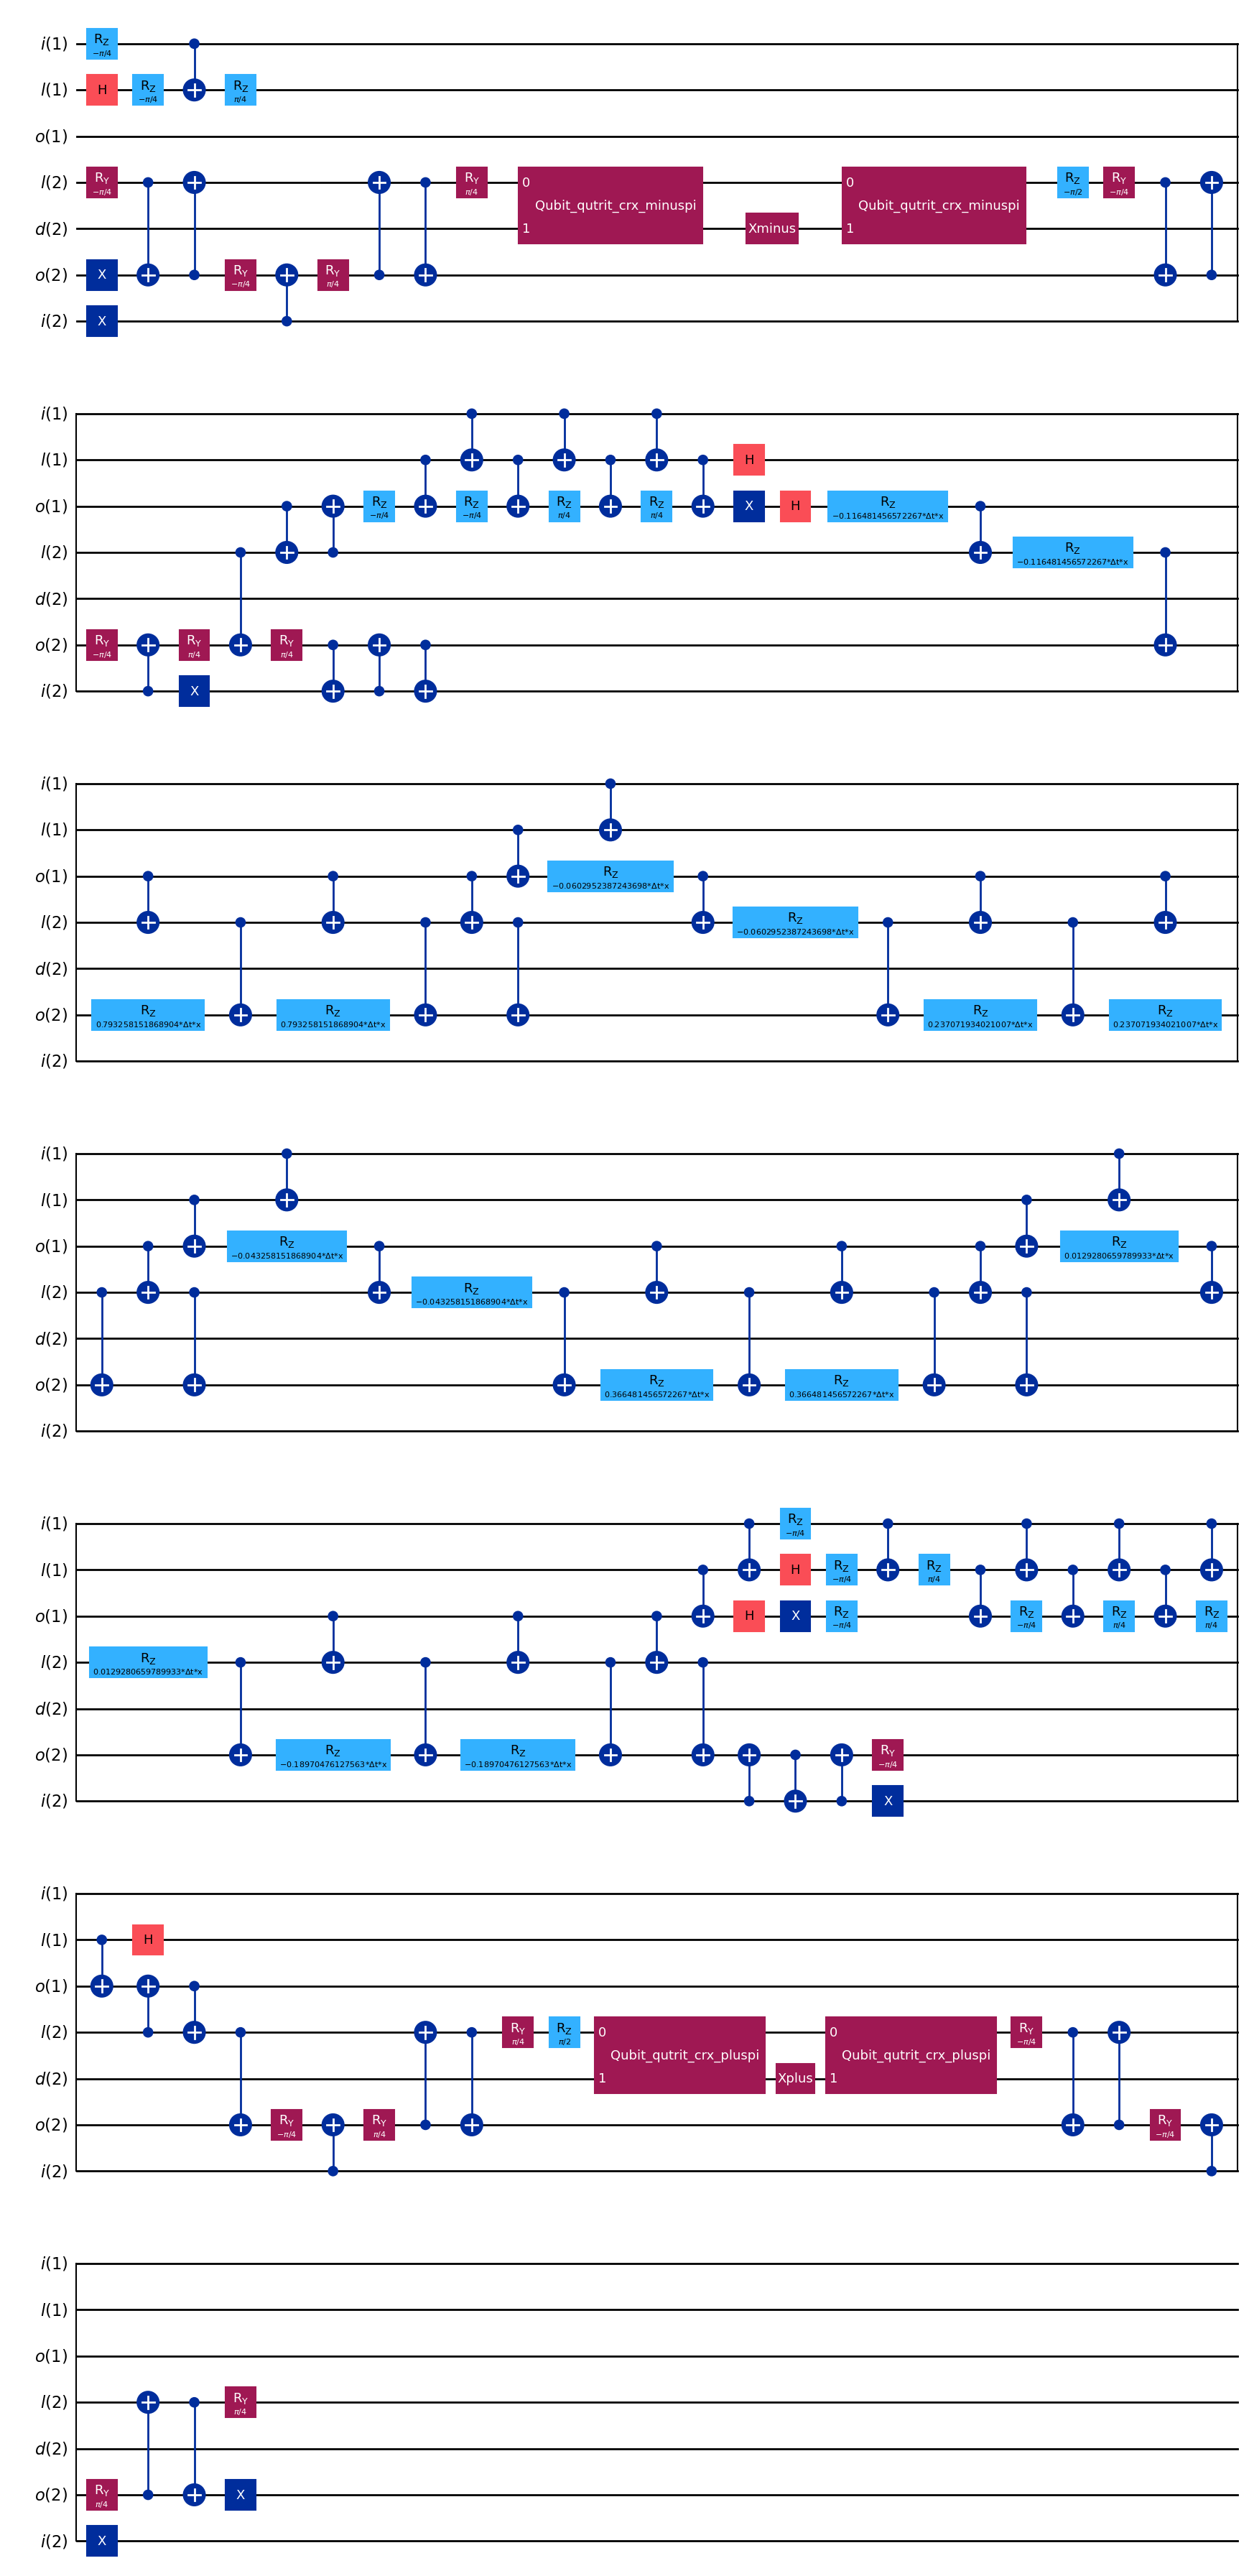

In [5]:
draw_circuit(precompiled, init_p, reorder=False)

## $H_M$

$$
\begin{align*}
H_{M}(r) &= H_{M}^{(1)}(r) + H_{M}^{(2)}(r)\,, \\
H_{M}^{(1)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{i(r)}\,,\\
H_{M}^{(2)}(r) &= \frac{\mu}{2}(-)^{r+1}Z_{o(r)}\,
\end{align*}
$$

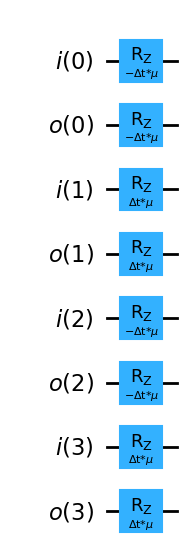

In [6]:
mass_qp = QubitPlacement(sum(([('i', site), ('o', site)] for site in range(4)), []))
mass_circuit = QuantumCircuit(mass_qp.num_qubits)
for site in range(4):
    circuit, init_p, _ = mass_term(site, time_step, mass_mu)
    mass_circuit.compose(circuit, qubits=[mass_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(mass_circuit, mass_qp, reorder=False)

In [7]:
assigned = sort_qubits(mass_circuit, mass_qp).assign_parameters({mass_mu: mu, time_step: dt})
op = np.zeros((2,) * (2 * num_sites))
pauliz = np.array([1., -1.])
for site in range(4):
    for io in range(2):
        dim = 2 * (4 - site) - io - 1
        extra_dims = list(range(dim)) + list(range(dim + 1, 8))
        op += np.expand_dims(pauliz * (-1 + 2 * (site % 2)), extra_dims)
op *= mu / 2. * dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, diagonal=True)

True

## $H_E$

$$
\begin{align}
H_{E}&=H_{E}^{(1)} + H_{E}^{(2)} + H_{E}^{(3)}
\\
H_{E}^{(1)} & = \frac{1}{2}n_{l}(r)\,,
\\
H_{E}^{(2)} & = \frac{1}{4}n_{l}(r)^{2}\,,
\\
H_{E}^{(3)} & = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)\,.
\end{align}
$$

### $H_E^{(1)} + H_E^{(2)} = \frac{1}{2}n_{l}(r) + \frac{1}{4}n_{l}(r)^{2}$

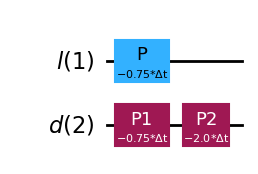

In [8]:
labels = [('l', 1), ('d', 2)]
electric_12_qp = QubitPlacement(labels)
electric_12_circuit = QuantumCircuit(electric_12_qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_12_term(site, time_step, **bc)
    electric_12_circuit.compose(circuit, qubits=[electric_12_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_12_circuit, electric_12_qp, reorder=False, fold=100)

In [9]:
assigned = sort_qubits(electric_12_circuit, electric_12_qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2))
op[:, 1] += 0.75
op[:] += np.array([0., 0.75, 2.])[:, None]
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(1,))

True

### $H_E^{(3)} = \frac{1}{2}\left[n_{l}(r)+\frac{3}{2}\right] n_{o}(r) \left(1-n_{i}(r)\right)$

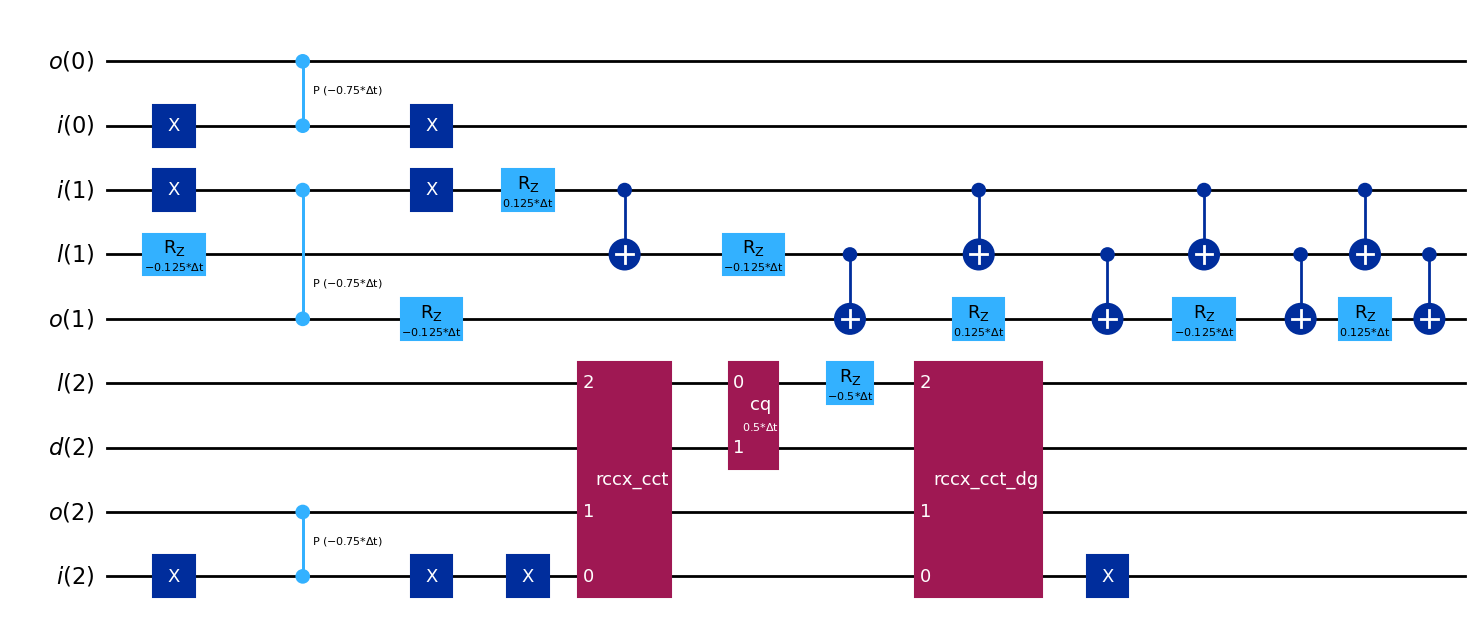

In [10]:
labels = [('o', 0), ('i', 0)]
labels += [('i', 1), ('l', 1), ('o', 1)]
labels += [('l', 2), ('d', 2), ('o', 2), ('i', 2)]
electric_3_qp = QubitPlacement(labels)
electric_3_circuit = QuantumCircuit(electric_3_qp.num_qubits)
for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circuit, init_p, _ = electric_3f_term(site, time_step)
    electric_3_circuit.compose(circuit, qubits=[electric_3_qp[lab] for lab in init_p.qubit_labels], inplace=True)
    circuit, init_p, _ = electric_3b_term(site, time_step, **bc)
    electric_3_circuit.compose(circuit, qubits=[electric_3_qp[lab] for lab in init_p.qubit_labels], inplace=True)
draw_circuit(electric_3_circuit, electric_3_qp, reorder=False, fold=100)

In [11]:
assigned = sort_qubits(electric_3_circuit.decompose(custom_gates), electric_3_qp).assign_parameters({time_step: dt})
op = np.zeros((3, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
hmat = np.diagflat(op)
validate_circuit(assigned, hmat, qutrits=(8,), ancillae=(7,))

True

## $H_I$

### $H_I^{(1)}$

The general form of $H_I^{(1)}$ is

$$
\begin{split}
\frac{1}{x} H_I^{(1)}(r) = & H_I^{(1)+}(r) + H_I^{(1)-}(r) \\
= & \ket{0}\bra{1}_{i(r)} Z_{o(r)} \ket{1}\bra{0}_{i(r+1)} \left[ \lambda^+_{l(r)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \right]^{1 - n_o(r)} \left[ \lambda^+_{l(r+1)}
\left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \right]^{n_o(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right) \\
& + \ket{1}\bra{0}_{i(r)} Z_{o(r)} \ket{0}\bra{1}_{i(r+1)} \mathcal{D}\left(n_l(r), n_o(r), n_o(r+1)\right)
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r)} \lambda^-_{l(r)} \right]^{1 - n_o(r)}
\left[ \left(1 - \ket{\Lambda}\bra{\Lambda}\right)_{l(r+1)} \lambda^-_{l(r+1)} \right]^{n_o(r+1)}
\end{split}
$$

Note that the combinations of the allowed $n_i$ and $n_o$ values together with AGL dictates that a
non-annihilated state will have $n_l(r) = n_l(r+1)$.


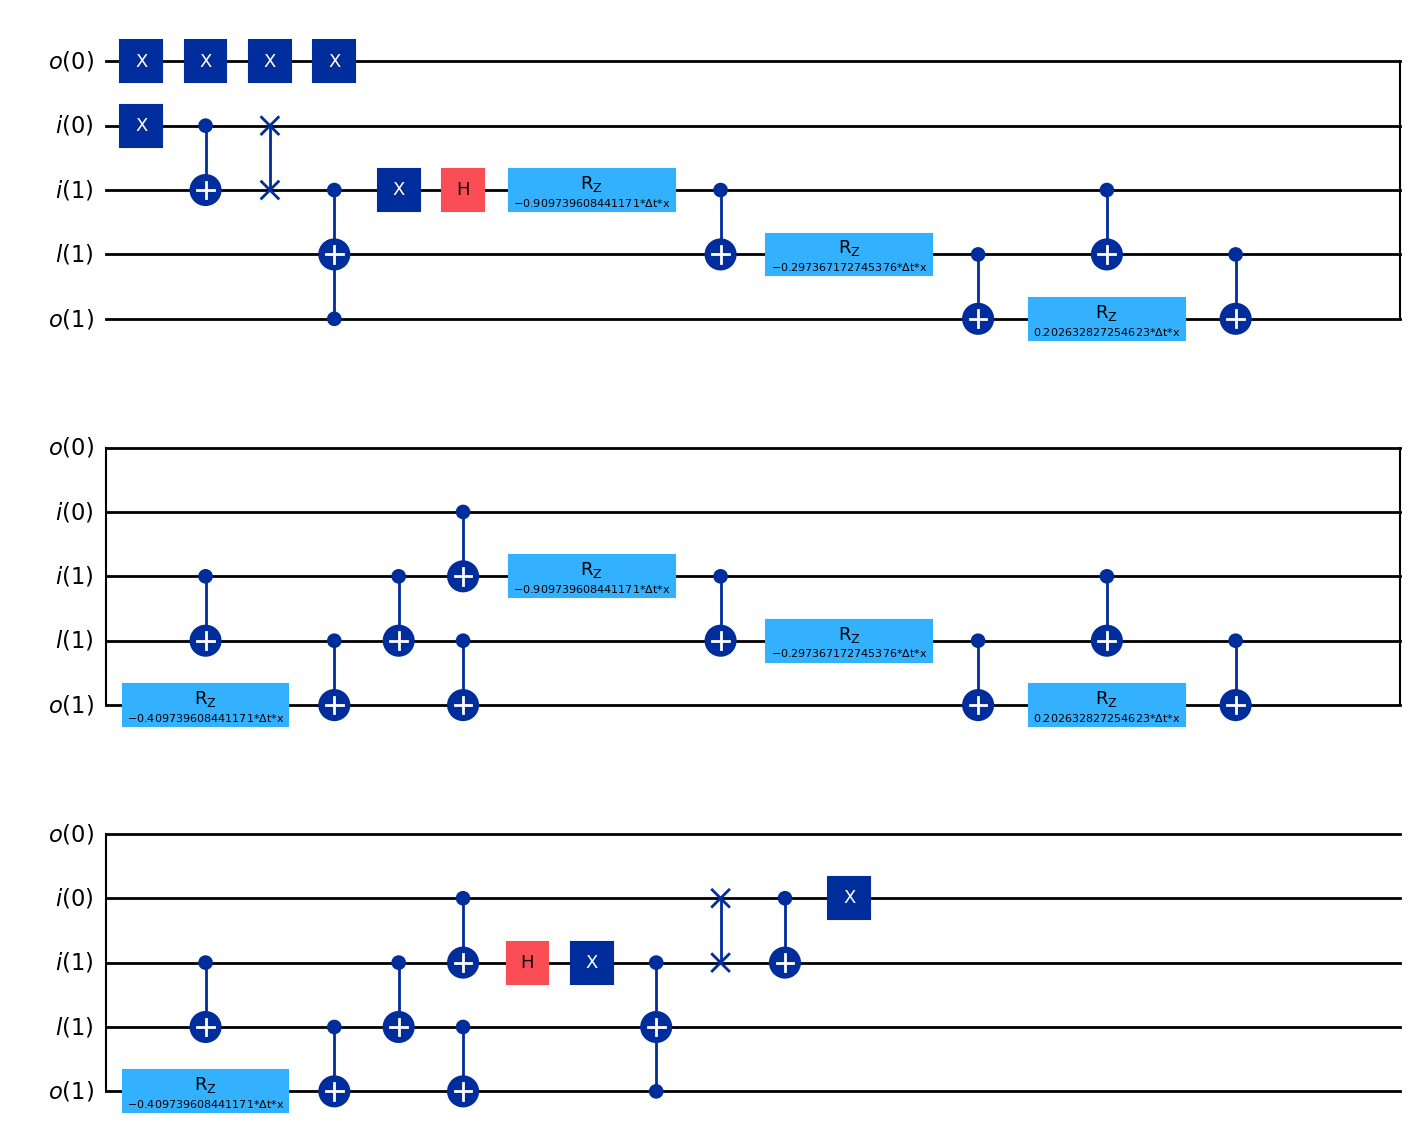

In [12]:
circuit, init_p, _ = hopping_term(1, 0, time_step, interaction_x, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=20)

In [13]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
# Reverse the site ordering through embedding
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

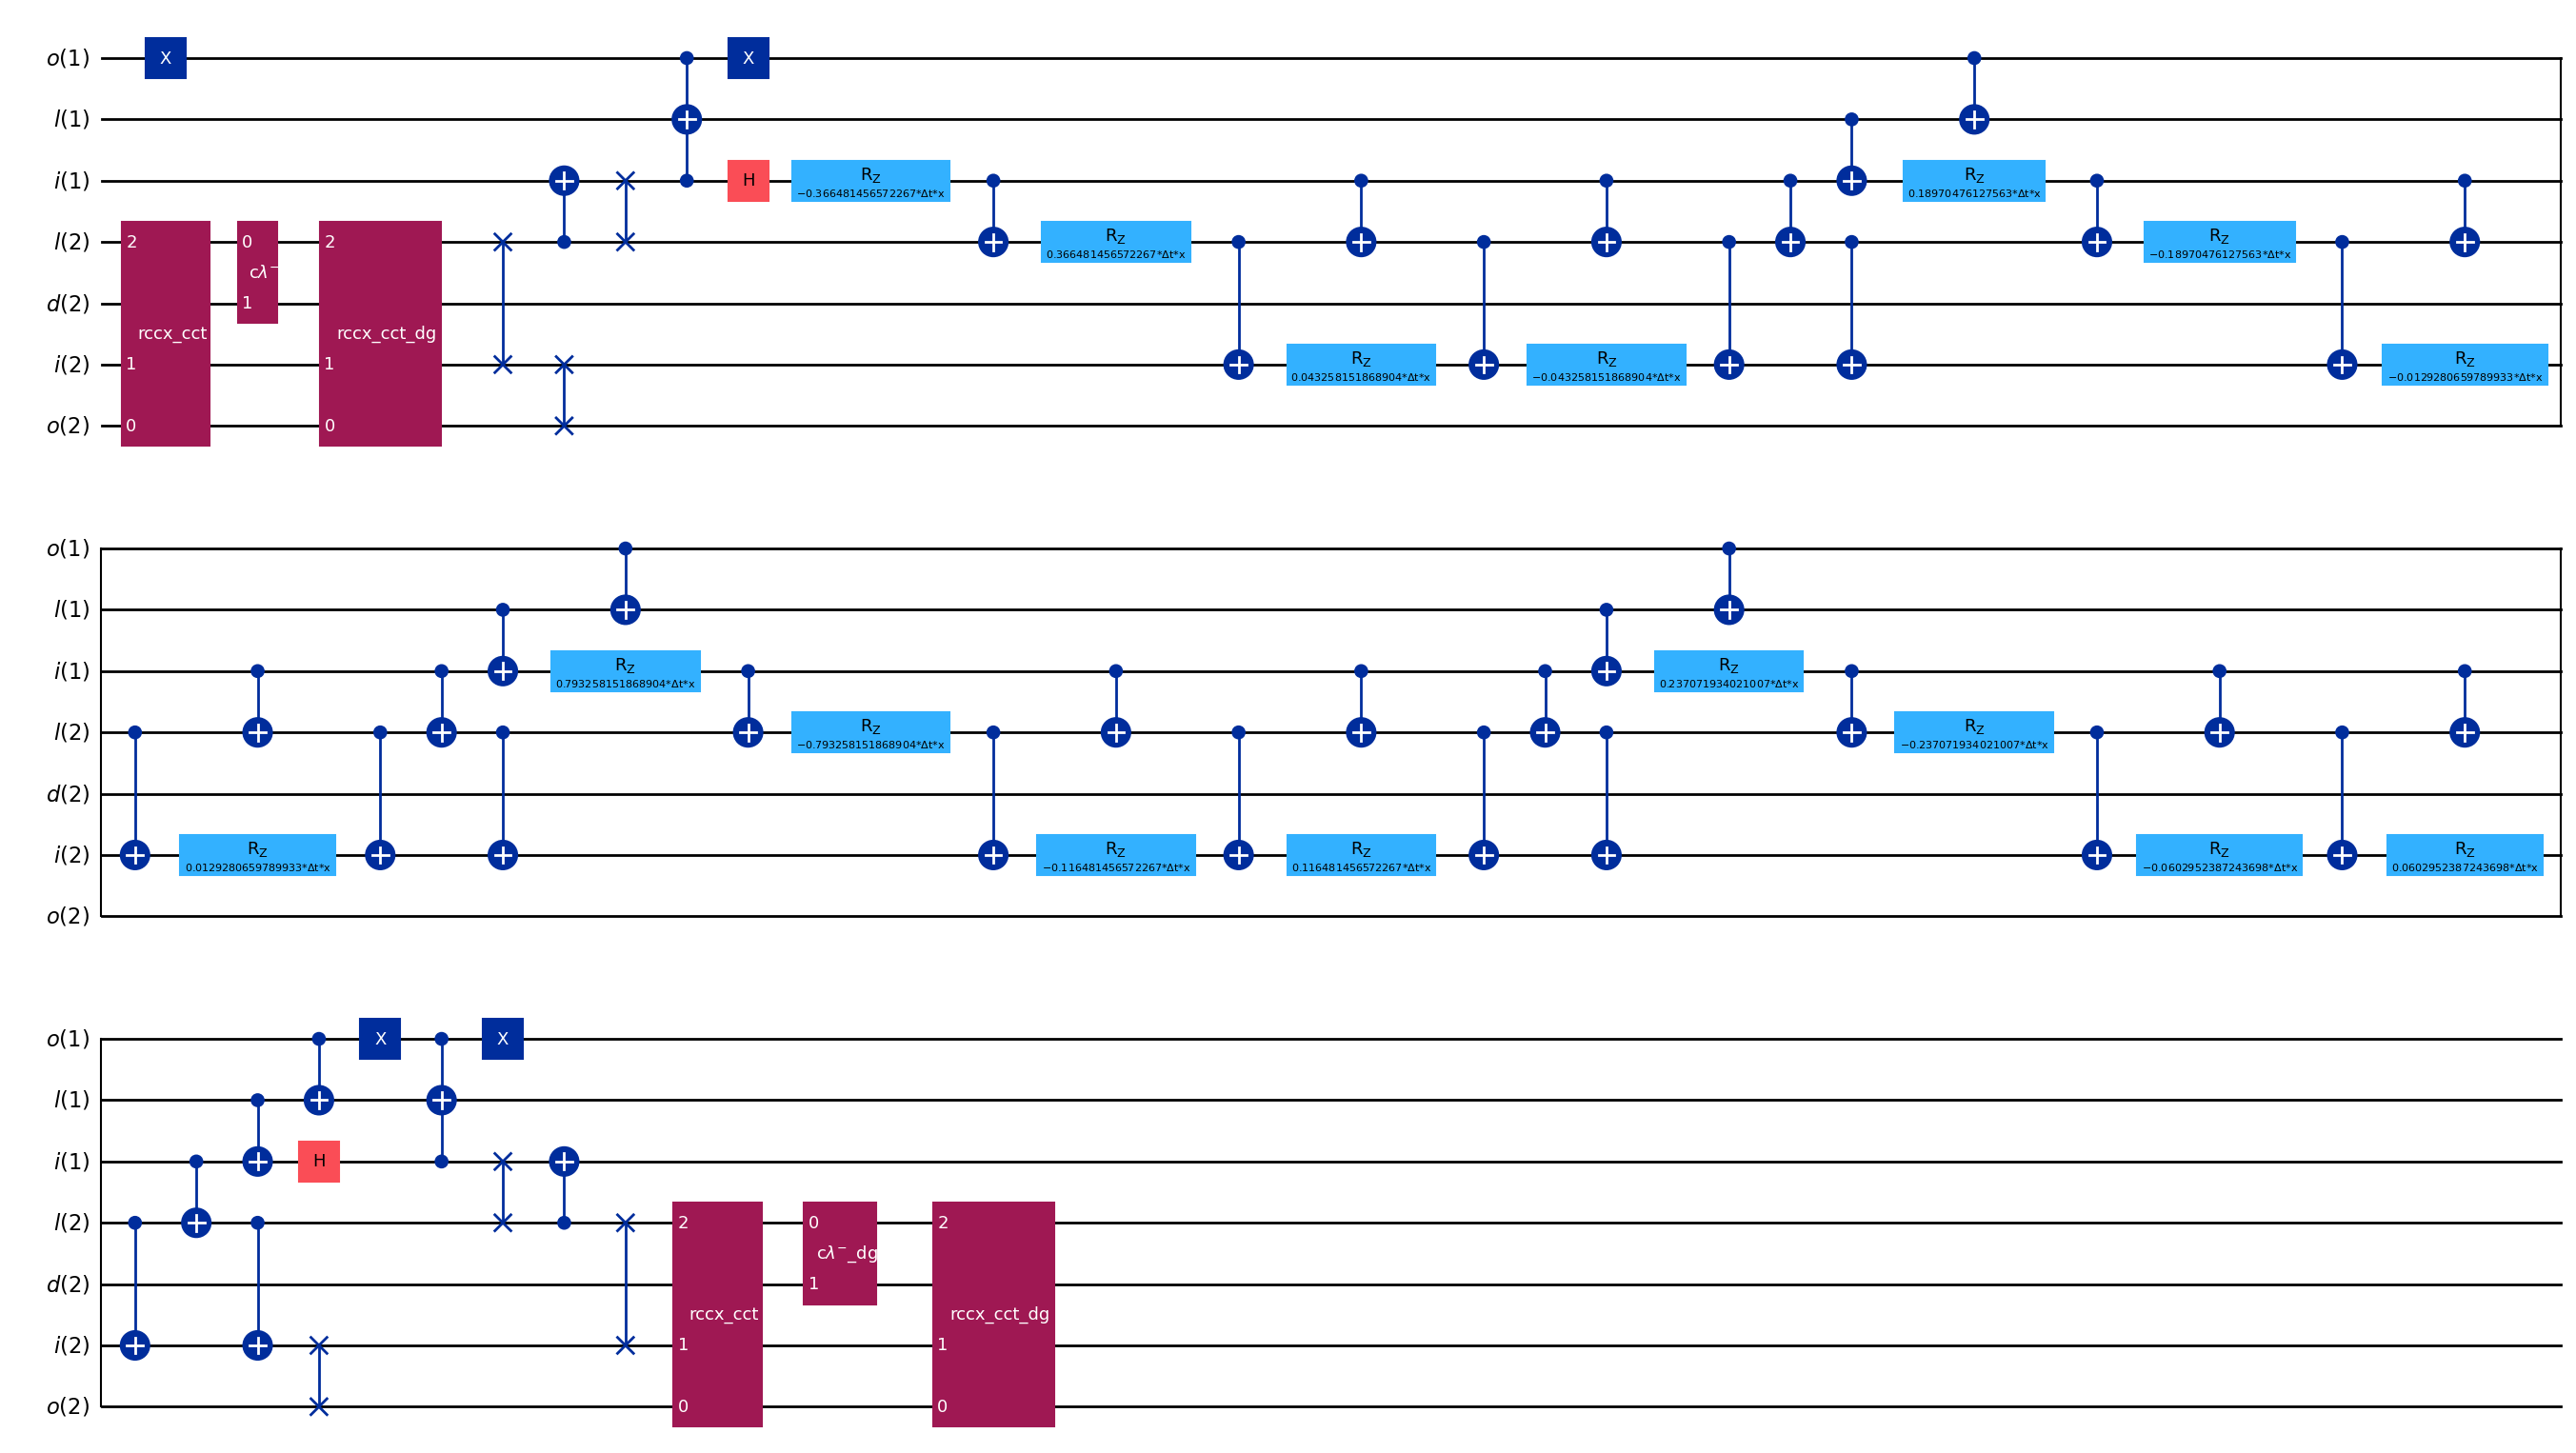

In [14]:
circuit, init_p, _ = hopping_term(1, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit.decompose(custom_gates), init_p, reorder=False, fold=40)

In [15]:
assigned = circuit.decompose(custom_gates, reps=2).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

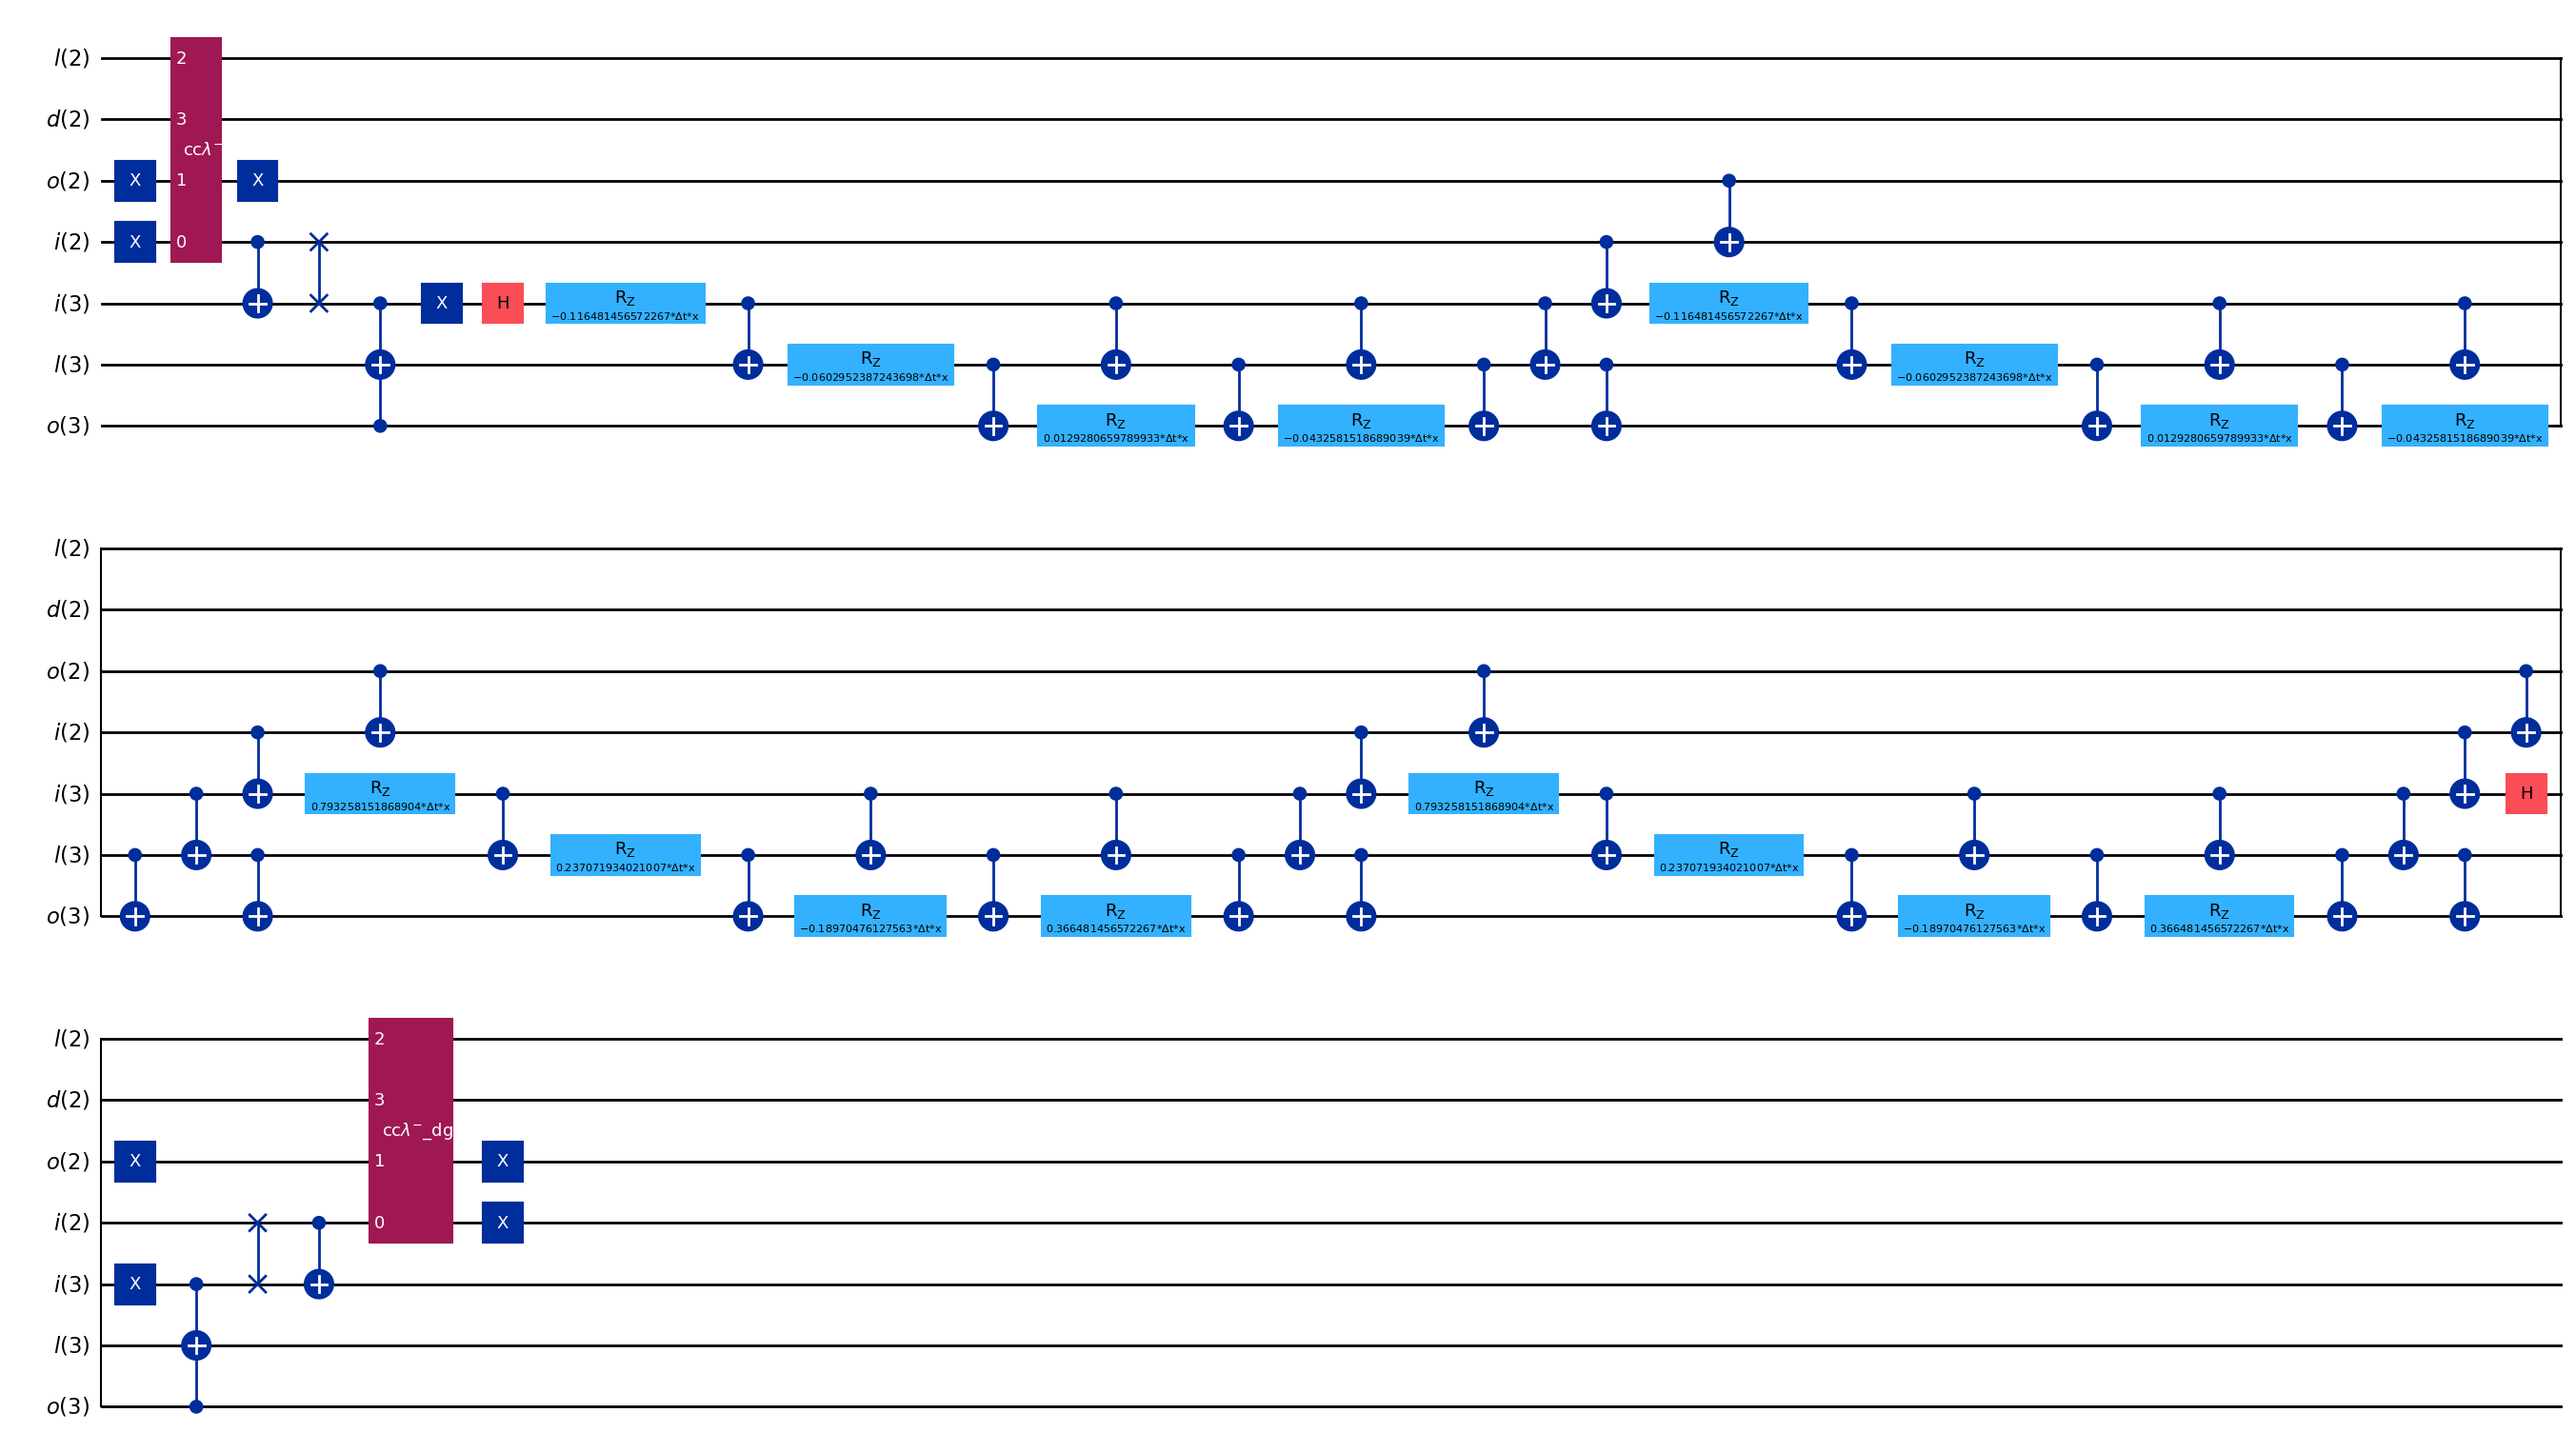

In [16]:
circuit, init_p, _ = hopping_term(1, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=40)

In [17]:
assigned = circuit.decompose(custom_gates, reps=2).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi1_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

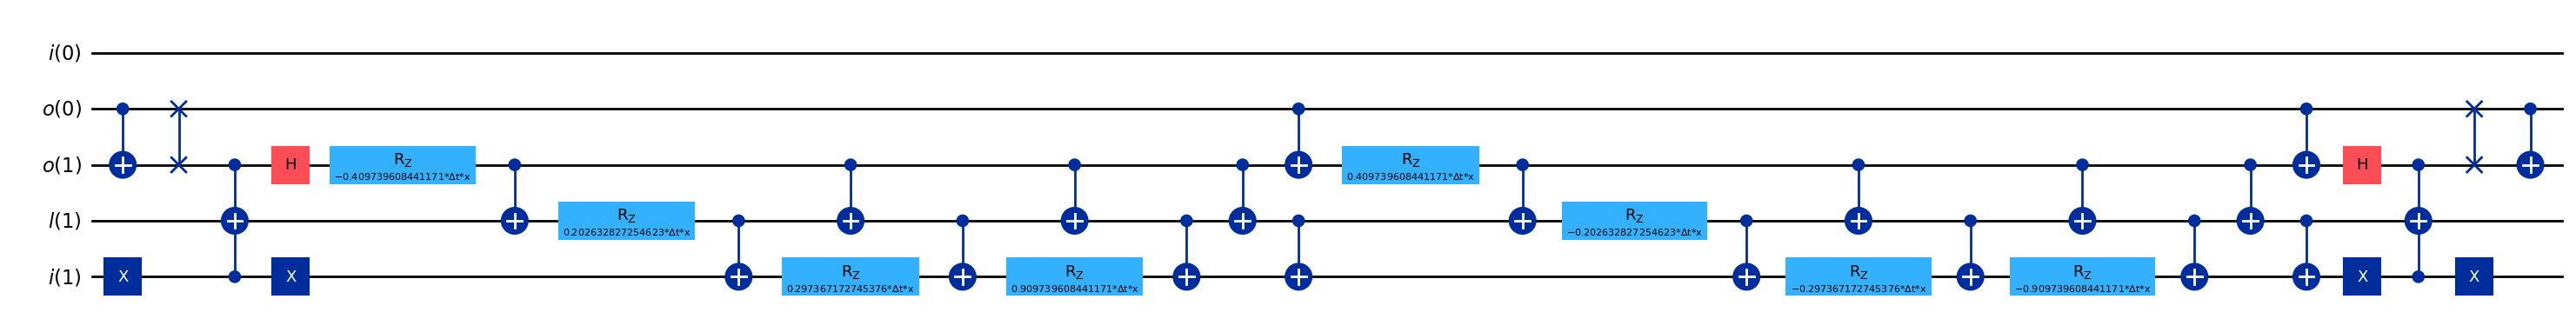

In [18]:
circuit, init_p, _ = hopping_term(2, 0, interaction_x, time_step, left_flux=0)
draw_circuit(circuit, init_p, reorder=False, fold=100)

In [19]:
assigned = circuit.assign_parameters({interaction_x: x, time_step: dt})
embedded_qp = QubitPlacement([('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
embedded = QuantumCircuit(embedded_qp.num_qubits)
embedded.compose(assigned, qubits=[embedded_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
subspace = np.sum(physical_states(left_flux=0, num_sites=2, as_multi=True) << np.arange(6)[None, ::-1], axis=1)
validate_circuit(embedded, hmat, subspace=subspace)

True

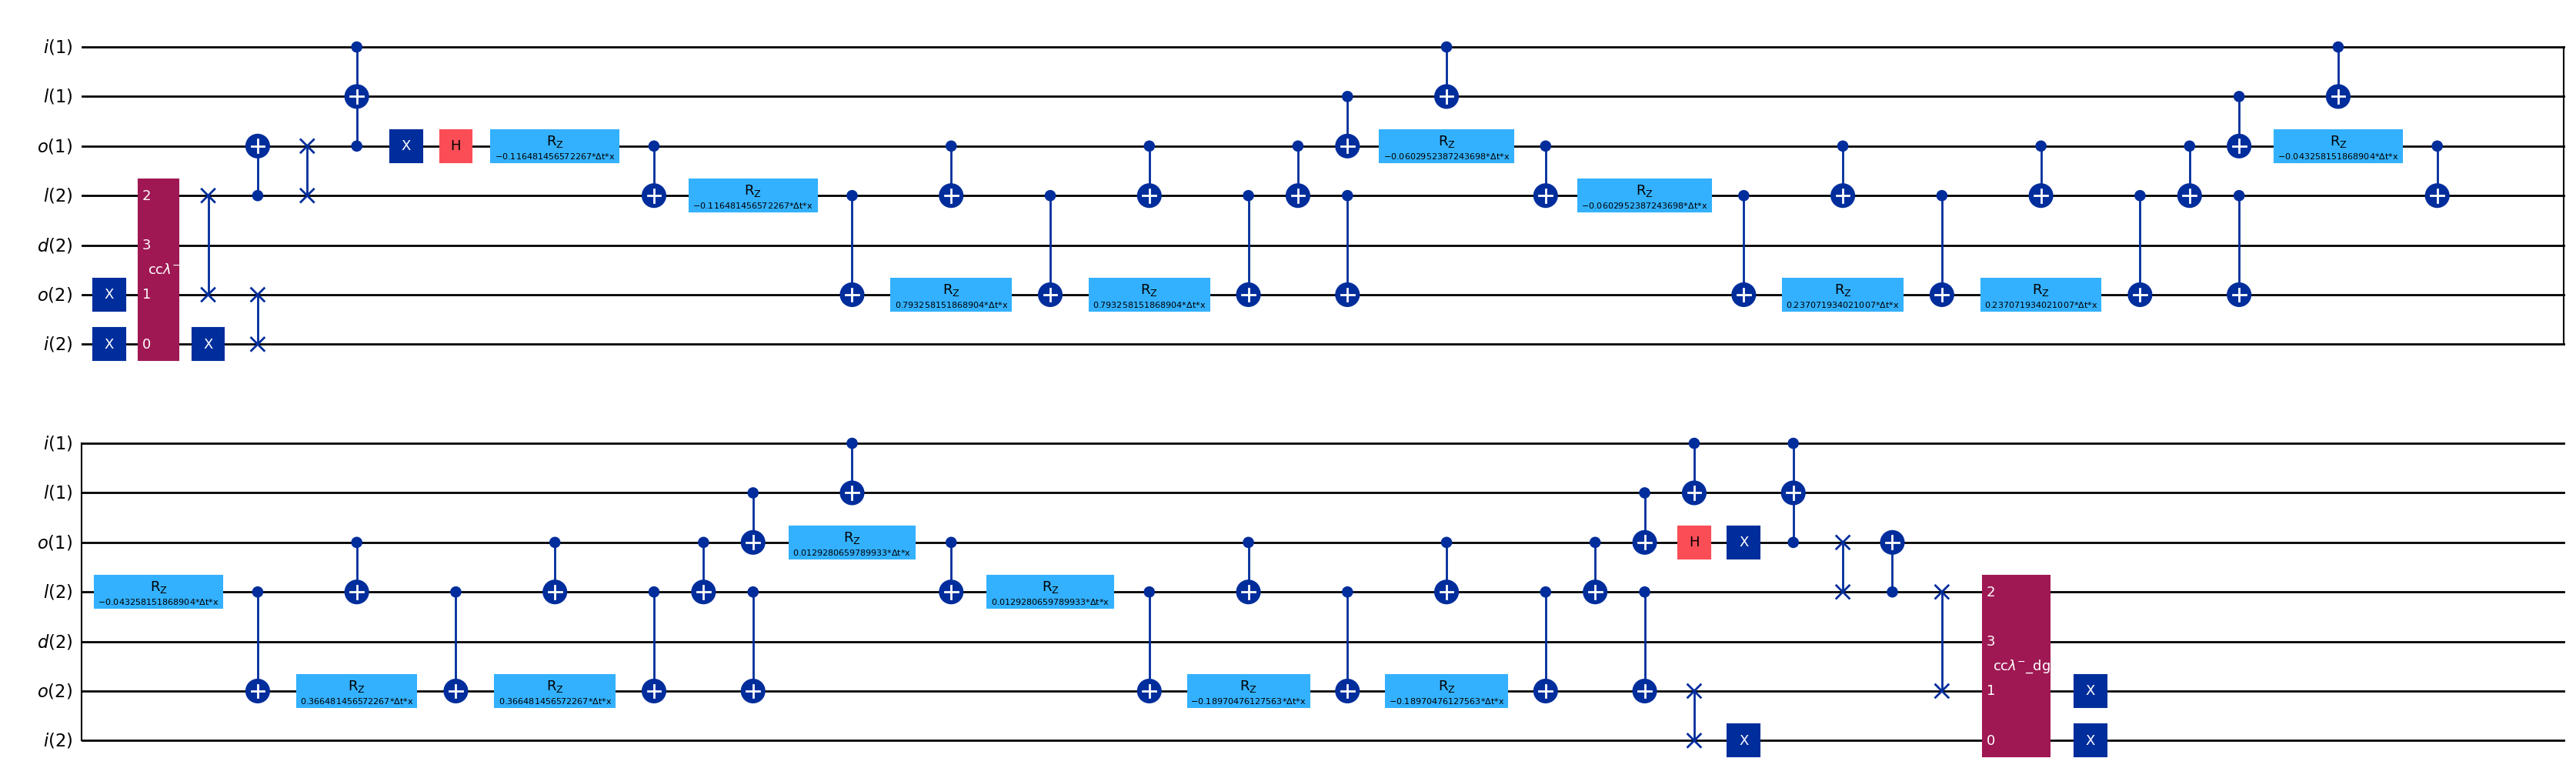

In [20]:
circuit, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [21]:
assigned = circuit.decompose(custom_gates, reps=2).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(left_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 3, 2, 2, 2, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(1,), ancillae=(0,), subspace=subspace)

True

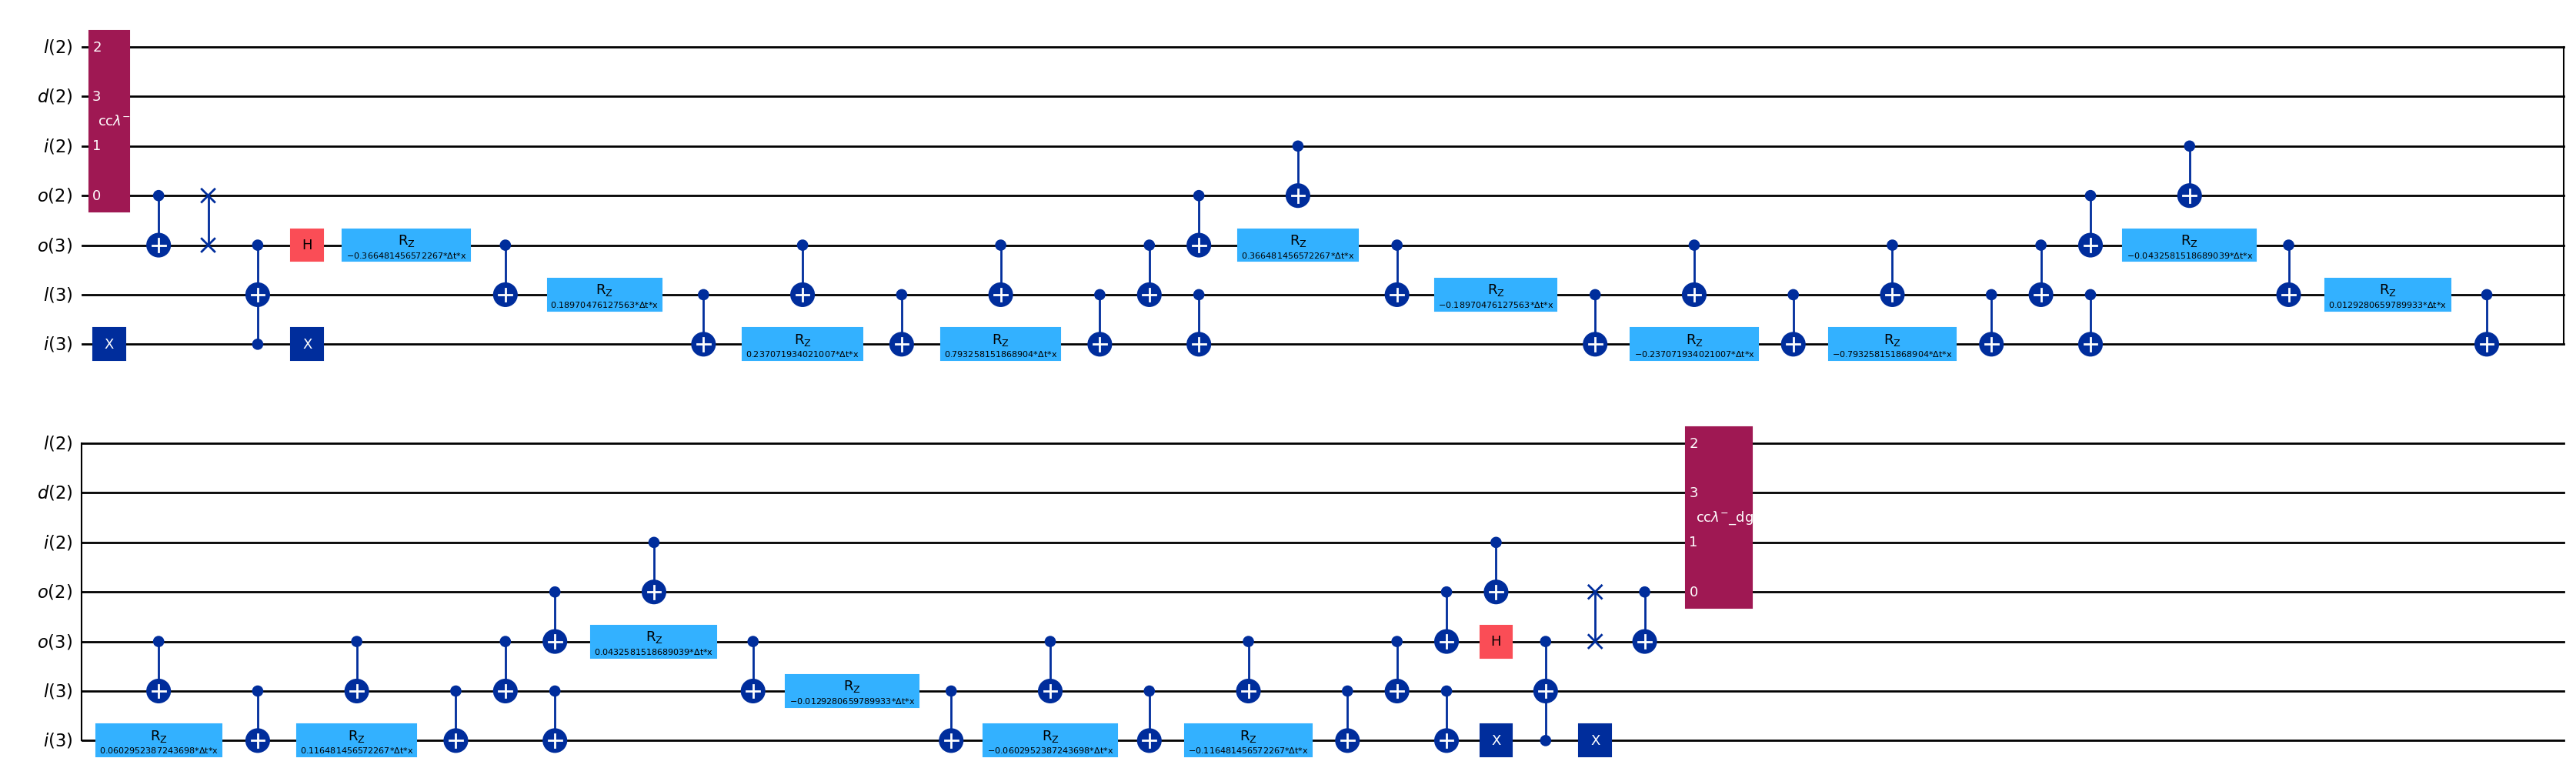

In [22]:
circuit, init_p, _ = hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1))
draw_circuit(circuit, init_p, reorder=False, fold=50)

In [23]:
assigned = circuit.decompose(custom_gates, reps=2).assign_parameters({interaction_x: x, time_step: dt})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in init_p.qubit_labels], inplace=True)
hmat = hi2_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
subspace = np.sum(physical_states(right_flux=(0, 1), num_sites=2, as_multi=True) * np.cumprod([1, 2, 2, 2, 3, 2])[None, ::-1], axis=1)
validate_circuit(ordered, hmat, qutrits=(4,), ancillae=(3,), subspace=subspace)

True

## Full circuit

In [24]:
from lsh_qudit.hamiltonian import hopping_term_config
configs = [hopping_term_config(ttype, site, left_flux=lflux, right_flux=rflux)
           for ttype, site, lflux, rflux in [(1, 0, 0, None), (1, 1, (0, 1), None), (1, 2, None, (0, 1)), (2, 0, 0, None), (2, 1, (0, 1), None), (2, 2, None, (0, 1))]]

config_itr = iter(configs)
for ttype in [1, 2]:
    for site in range(3):
        config = next(config_itr)
        print(ttype, site, config.boson_ops['p'], config.boson_ops['q'])

1 0 ('id', 'id') ('X', 'zero')
1 1 ('X', 'zero') ('lambda', 'id')
1 2 ('lambda', 'id') ('X', 'zero')
2 0 ('X', 'zero') ('id', 'id')
2 1 ('lambda', 'id') ('X', 'zero')
2 2 ('X', 'zero') ('lambda', 'id')


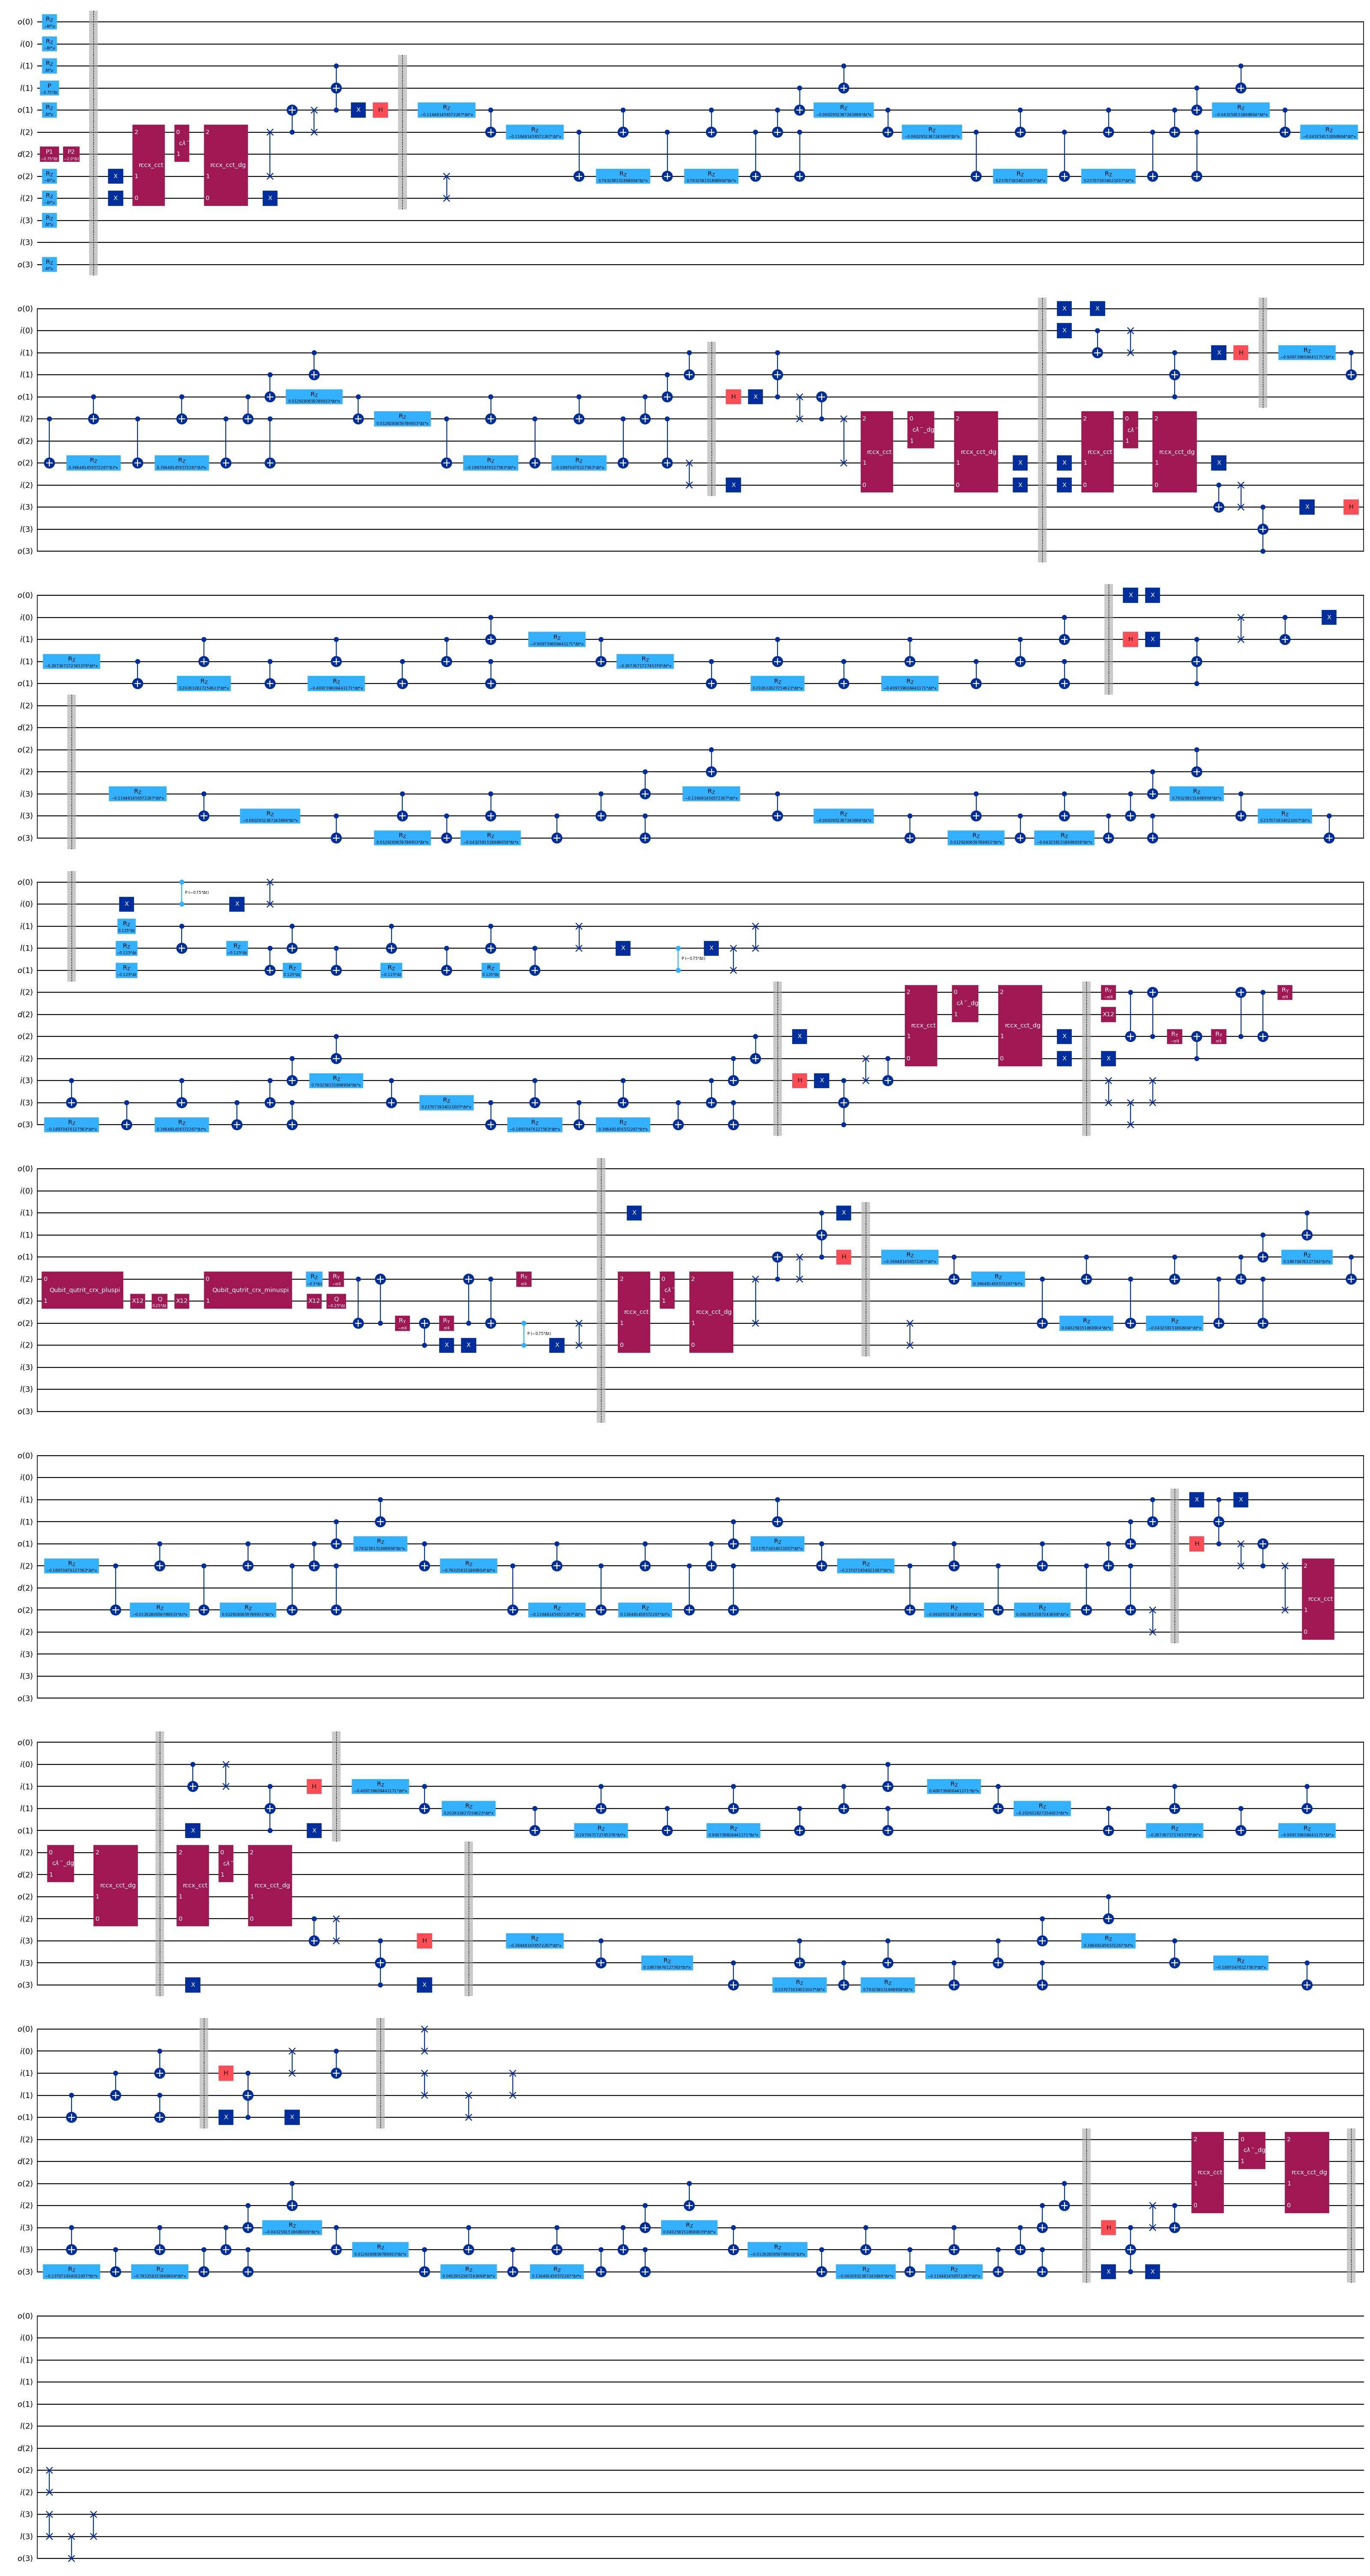

In [25]:
full_qp = QubitPlacement(
    [('o', 0), ('i', 0)]
    + [('i', 1), ('l', 1), ('o', 1)]
    + [('l', 2), ('d', 2), ('o', 2), ('i', 2)]
    + [('i', 3), ('l', 3), ('o', 3)]
)
full_circuit = QuantumCircuit(full_qp.num_qubits)

def swap(qp, l1, l2):
    full_circuit.swap(qp[l1], qp[l2])
    return qp.swap(l1, l2)

full_circuit.compose(mass_circuit, qubits=[full_qp[label] for label in mass_qp.qubit_labels], inplace=True)
full_circuit.compose(electric_12_circuit, qubits=[full_qp[label] for label in electric_12_qp.qubit_labels], inplace=True)
full_circuit.barrier()

circ, init_p, _ = hopping_term(2, 1, time_step, interaction_x, left_flux=(0, 1), with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier()

circ, init_p, _ = hopping_term(1, 0, time_step, interaction_x, left_flux=0, with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([full_qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(1, 2, time_step, interaction_x, right_flux=(0, 1), with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([full_qp[label] for label in init_p.qubit_labels])

for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circ, init_p, _ = electric_3b_term(site, time_step, **bc)
    full_circuit.compose(circ, qubits=[full_qp[lab] for lab in init_p.qubit_labels], inplace=True)

full_qp = swap(full_qp, ('i', 1), ('l', 1))
full_qp = swap(full_qp, ('i', 3), ('l', 3))

for site, bc in enumerate([{'left_flux': 0}, {'left_flux': (0, 1)}, {}]):
    circ, init_p, _ = electric_3f_term(site, time_step)
    full_circuit.compose(circ, qubits=[full_qp[lab] for lab in init_p.qubit_labels], inplace=True)

full_qp = swap(full_qp, ('o', 0), ('i', 0))
full_qp = swap(full_qp, ('i', 1), ('o', 1))
full_qp = swap(full_qp, ('l', 1), ('o', 1))
full_qp = swap(full_qp, ('o', 2), ('i', 2))
full_qp = swap(full_qp, ('i', 3), ('o', 3))
full_qp = swap(full_qp, ('l', 3), ('o', 3))
full_circuit.barrier()

circ, init_p, _ = hopping_term(1, 1, time_step, interaction_x, left_flux=(0, 1), with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier()

circ, init_p, _ = hopping_term(2, 0, time_step, interaction_x, left_flux=0, with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([full_qp[label] for label in init_p.qubit_labels])

circ, init_p, _ = hopping_term(2, 2, time_step, interaction_x, right_flux=(0, 1), with_barrier=True)
full_circuit.compose(circ, qubits=[full_qp[label] for label in init_p.qubit_labels], inplace=True)
full_circuit.barrier([full_qp[label] for label in init_p.qubit_labels])

full_qp = swap(full_qp, ('l', 3), ('o', 3))
full_qp = swap(full_qp, ('i', 3), ('o', 3))
full_qp = swap(full_qp, ('i', 3), ('l', 3))
full_qp = swap(full_qp, ('o', 2), ('i', 2))
full_qp = swap(full_qp, ('l', 1), ('o', 1))
full_qp = swap(full_qp, ('i', 1), ('o', 1))
full_qp = swap(full_qp, ('i', 1), ('l', 1))
full_qp = swap(full_qp, ('o', 0), ('i', 0))

draw_circuit(full_circuit.decompose(custom_gates), full_qp, reorder=False, scale=0.8, fold=60)

In [26]:
precompile_pm = PassManager(
    [
        RemoveBarriers(),
        InverseCancellation([XGate(), HGate(), CXGate(), CCXGate(), SwapGate()]),
        LSHPrecompiler(),
        InverseCancellation([XGate(), HGate(), CXGate(), CCXGate(), SwapGate(),
                             X12Gate(), (XplusGate(), XminusGate()), (QubitQutritCRxMinusPiGate(), QubitQutritCRxPlusPiGate())])
    ]
)
precompiled = precompile_pm.run(full_circuit)
precompiled.count_ops()

OrderedDict([('cx', 436),
             ('rz', 193),
             ('ry', 40),
             ('h', 32),
             ('x', 30),
             ('qubit_qutrit_crx_minuspi', 5),
             ('qubit_qutrit_crx_pluspi', 5),
             ('x12', 4),
             ('xminus', 2),
             ('xplus', 2),
             ('q', 2),
             ('p', 1),
             ('p1', 1),
             ('p2', 1)])

In [27]:
assigned = precompiled.assign_parameters({interaction_x: x, time_step: dt, mass_mu: mu})
#assigned = precompiled.assign_parameters({time_step: dt, mass_mu: mu})
ordered_qp = QubitPlacement([('l', 3), ('o', 3), ('i', 3), ('l', 2), ('d', 2), ('o', 2), ('i', 2), ('l', 1), ('o', 1), ('i', 1), ('l', 0), ('o', 0), ('i', 0)])
ordered = QuantumCircuit(ordered_qp.num_qubits)
ordered.compose(assigned, qubits=[ordered_qp[lab] for lab in full_qp.qubit_labels], inplace=True)

shape = (2, 2, 2) + (2, 2, 2) + (2, 2, 3) + (2, 2, 2)
qutrits = (4,)
ancillae = (3,)

umat = np.eye(np.prod(shape), dtype=np.complex128)

# HM
op = np.zeros((2,) * (2 * num_sites))
pauliz = np.array([1., -1.])
for site in range(4):
    for io in range(2):
        dim = 2 * (4 - site) - io - 1
        extra_dims = list(range(dim)) + list(range(dim + 1, 8))
        op += np.expand_dims(pauliz * (1 - 2 * (site % 2)), extra_dims)
op *= mu / 2. * dt
umat = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, [11, 10, 8, 7, 5, 4, 2, 1]) @ umat

# HE[12]
op = np.zeros((2, 3))
op[1] += 0.75
op += np.array([0., 0.75, 2.])
op *= dt
umat = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, [6, 3]) @ umat

# HI[2](1)
hmat = hi2_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1))) @ umat
# HI[1](0)
hmat = hi1_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1))) @ umat
# HI[1](2)
hmat = hi1_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1))) @ umat

# HE[3]
op = np.zeros((3, 2, 2, 2, 2, 2, 2, 2))
op[:, :, :, :, :, :, 1, 0] += 0.75
op[:, :, :, :, 1, 0] += 0.75
op[:, :, :, 1, 1, 0] += 0.5
op[:, 1, 0] += 0.75
op[1, 1, 0] += 0.5
op[2, 1, 0] += 1.
op *= dt
umat = op_matrix(np.diagflat(np.exp(-1.j * op)), shape, list(range(3, 9)) + [10, 11]) @ umat

# HI[1](1)
hmat = hi1_mat.reshape(4, 3, 12, 4, 3, 12)[:, :2, :, :, :2, :].reshape(96, 96) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(8, 2, -1))) @ umat
# HI[2](0)
hmat = hi2_mat.reshape(4, 3, 4, 3, 4, 3, 4, 3)[:, :2, :, :2, :, :2, :, :2].reshape(64, 64) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(11, 5, -1))) @ umat
# HI[2](2)
hmat = hi2_mat.reshape(12, 4, 3, 12, 4, 3)[:, :, :2, :, :, :2].reshape(96, 96) * x * dt
umat = op_matrix(scipy.linalg.expm(-1.j * hmat), shape, list(range(5, -1, -1))) @ umat

subspace = np.sum(physical_states(left_flux=0, right_flux=(0, 1), num_sites=4, as_multi=True) * np.cumprod((1,) + shape[-1:0:-1])[None, ::-1], axis=1)
validate_circuit(ordered, umat, qutrits=qutrits, ancillae=ancillae, exponentiate=False, subspace=subspace)

True

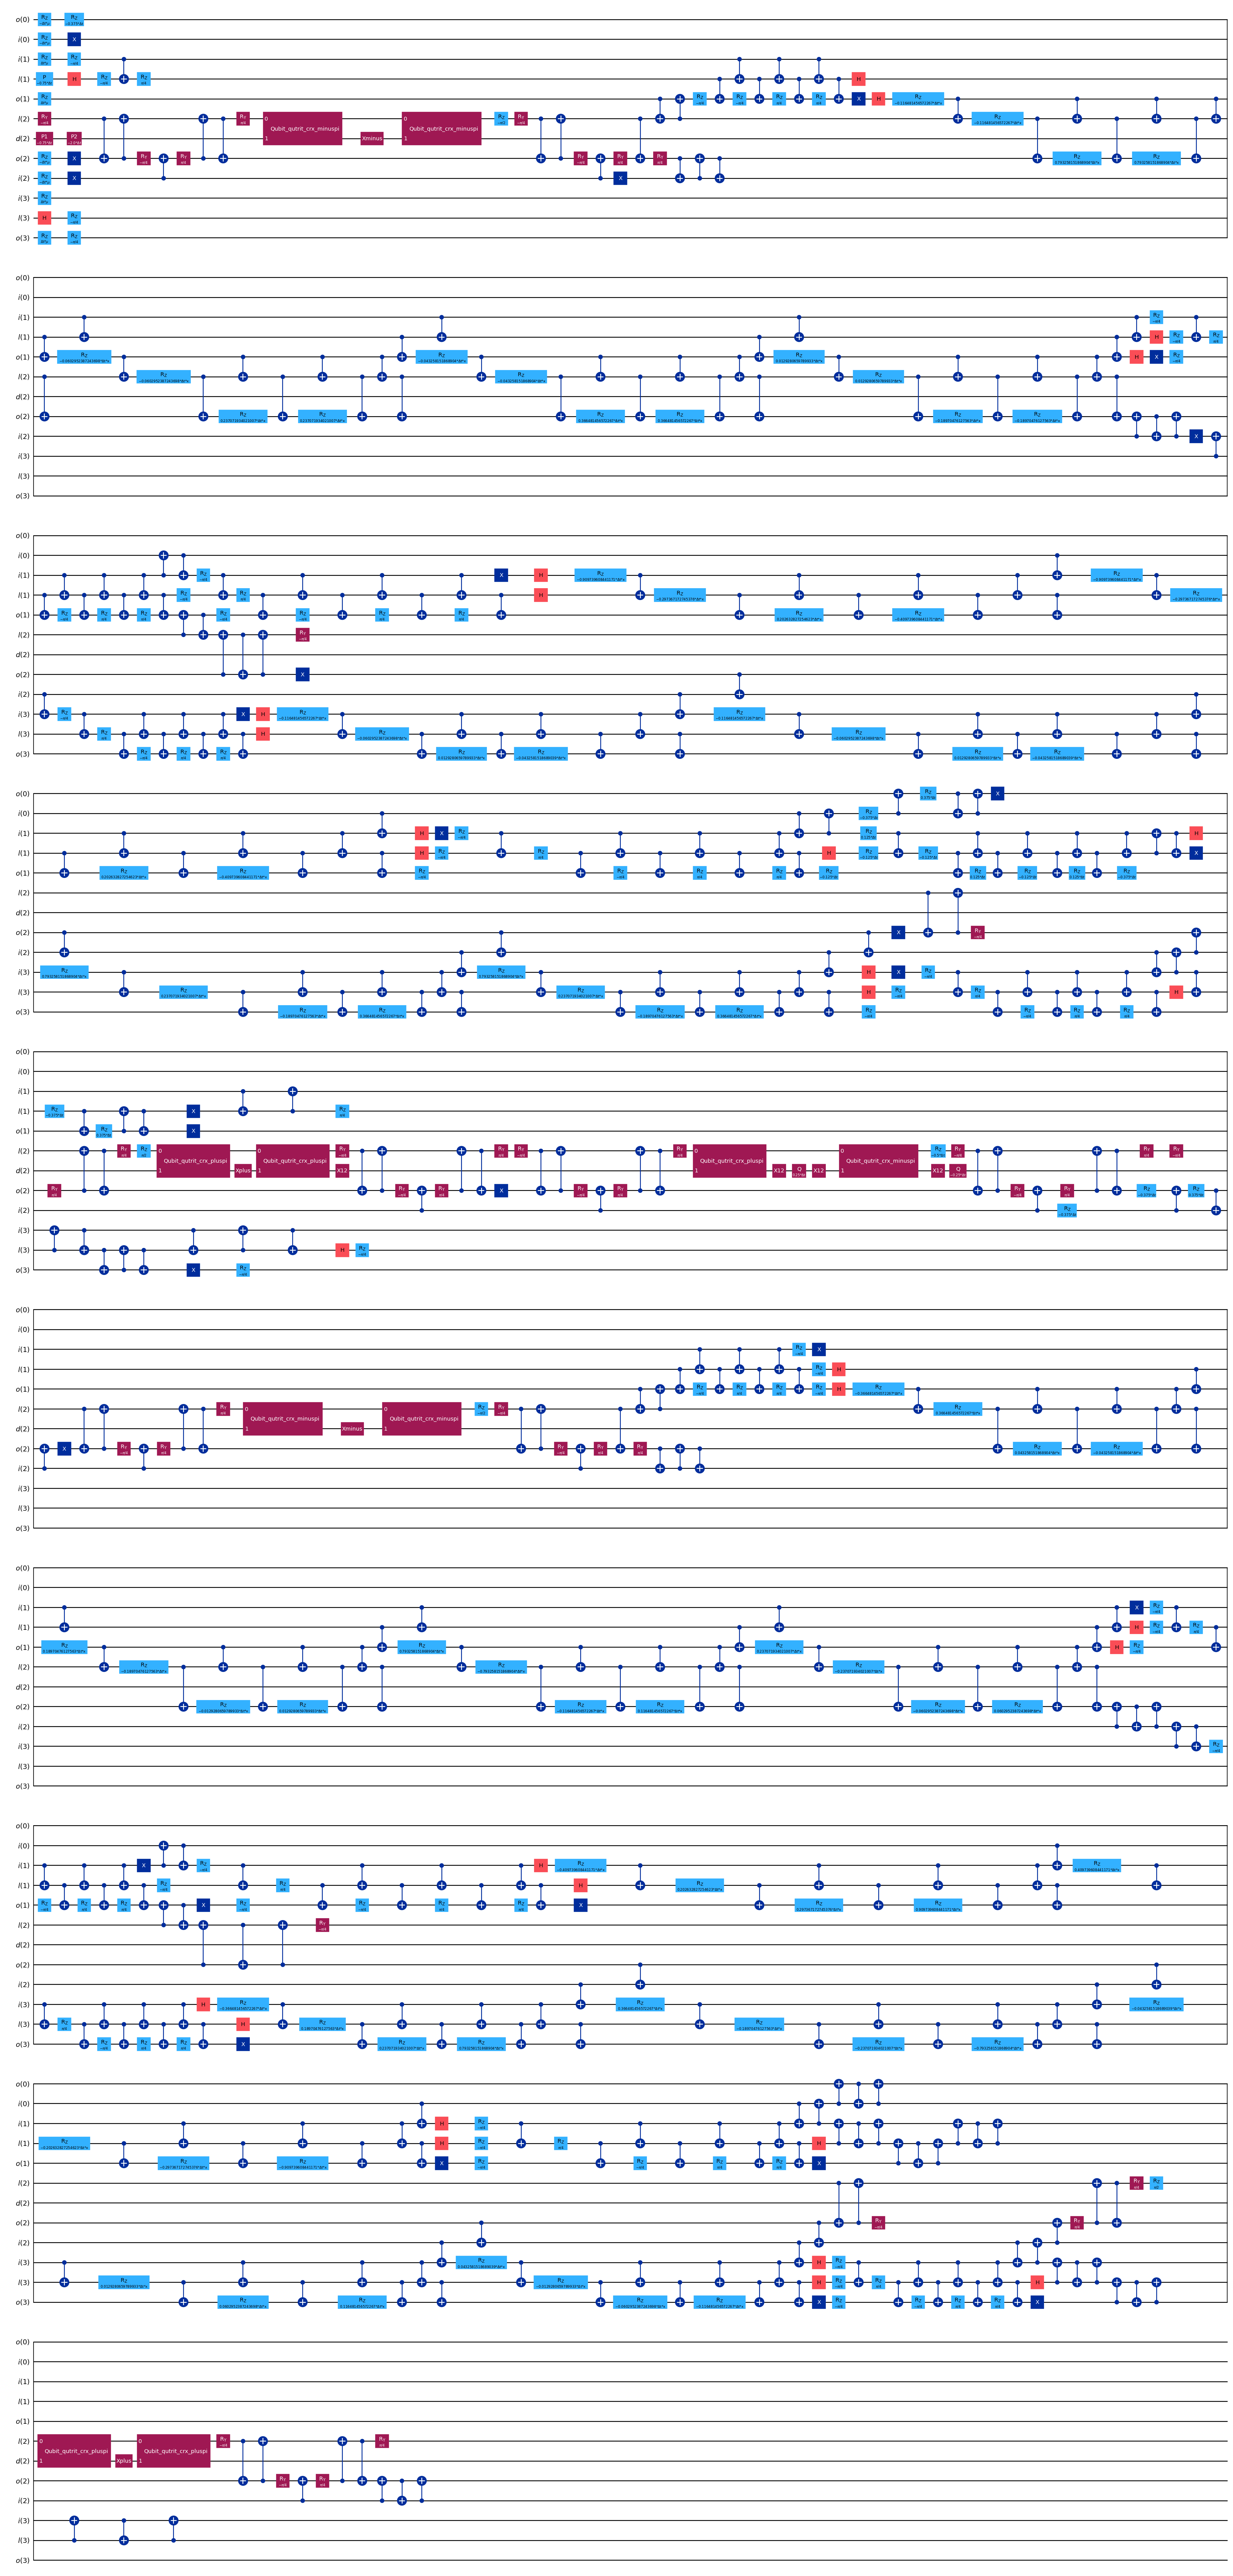

In [28]:
draw_circuit(precompiled, full_qp, reorder=False, scale=0.8, fold=60)

In [29]:
from qiskit.transpiler.passes.optimization import Collect2qBlocks, ConsolidateBlocks

backend = FakeTorino()

# Initial mapping of occupation numbers to physical qubits (i and o get swapped)
#                d2
# o0-i0-i1-l1-o1-l2-o2-i2-i3-l3-o3
layout = {
    ('o', 0): 3,
    ('i', 0): 4,
    ('i', 1): 5,
    ('l', 1): 6,
    ('o', 1): 7,
    ('l', 2): 8,
    ('d', 2): 17,
    ('o', 2): 9,
    ('i', 2): 10,
    ('i', 3): 11,
    ('l', 3): 12,
    ('o', 3): 13
}

qutrit_gates = ['qubit_qutrit_crx_minuspi', 'qubit_qutrit_crx_pluspi', 'x12', 'rz12']
preset_pm = generate_preset_pass_manager(optimization_level=3, backend=backend,
                                         initial_layout=[layout[label] for label in full_qp.qubit_labels],
                                         basis_gates=backend.configuration().basis_gates + qutrit_gates)
stage_pms = {}
for stage in preset_pm.expanded_stages:
    if (pm := getattr(preset_pm, stage, None)) is not None:
        stage_pms[stage] = pm
stage_pms['precompile'] = precompile_pm

idx = next(idx for idx, pass_set in enumerate(stage_pms['init']._tasks) if isinstance(pass_set[0], Collect2qBlocks))
stage_pms['init'].remove(idx)
idx = next(idx for idx, pass_set in enumerate(stage_pms['init']._tasks) if isinstance(pass_set[0], ConsolidateBlocks))
stage_pms['init'].remove(idx)
stage_pms['optimization']._tasks[1][0].tasks = stage_pms['optimization']._tasks[1][0].tasks[2:]

pm = StagedPassManager(stages=('precompile',) + preset_pm.stages, **stage_pms)

In [30]:
transpiled = pm.run(full_circuit)

In [31]:
transpiled.count_ops()

OrderedDict([('rz', 948),
             ('sx', 786),
             ('cz', 434),
             ('x', 10),
             ('qubit_qutrit_crx_minuspi', 5),
             ('qubit_qutrit_crx_pluspi', 5),
             ('rz12', 4),
             ('x12', 2)])